In [1]:
import copy
import math

import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.metrics import zero_one_loss, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator

from tqdm.notebook import tqdm as log_progress

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import animation

%matplotlib notebook

In [2]:
def load_dataset(filepath):
    ds_tmp = pd.read_csv(filepath)
    ctoi = {'P': 1, 'N': -1}
    Y = ds_tmp[['class']].applymap(lambda x : ctoi[x])
    X = ds_tmp.loc[:, ds_tmp.columns != 'class']
    return X, Y

In [13]:
EPS = 1e-6
class AdaptiveBoost(BaseEstimator):
    def __init__(self, count):
        self.count = count
        self.clfs = None
        self.clfsw = None
    
    def fit(self, X, Y):
        n, _ = X.shape
        weights = np.repeat(1 / n, n)
        clfs = [tree.DecisionTreeClassifier(max_depth=1) for _ in range(self.count)]
        clfsw = []
        
        for clf in clfs:
            clf.fit(X, Y, sample_weight=weights)
            predicted_Y = clf.predict(X)
            error = zero_one_loss(Y, predicted_Y, normalize=False, sample_weight=weights)
            beta = 0.5 * np.log((1 - error) / error)
            clfsw.append(alpha)
            weights = weights * np.exp(-beta * (Y.values.T[0] * predicted_Y))
            weights /= np.sum(weights)
            
        self.clfsw = np.array(clfsw)
        self.clfs = np.array(clfs)
        
    def predict(self, tX):
        n, _ = tX.shape
        result = np.zeros(n)
        for clf, weight in zip(self.clfs, self.clfsw):
            result += weight * clf.predict(tX)
        return np.sign(result)

In [4]:
def build_prediction_grid(clf, points_x, points_y):
    grid = np.fromfunction(lambda i, j: i - i, (len(points_x), len(points_y)), dtype=int)
    # print(grid)
    dot = np.empty((1, 2))
    for i in range(len(points_y)):
        dot[0][1] = points_y[i]
        for j in range(len(points_x)):
            dot[0][0] = points_x[j]
            grid[i][j] = clf.predict(dot)[0]            
    return grid    

In [5]:
counts = [1, 2, 3, 5, 8, 13, 21, 34, 55, 100]
chipsX, chipsY = load_dataset('chips.csv')
chips = pd.read_csv('chips.csv')
clfs = [AdaptiveBoost(c) for c in counts]
for clf in clfs:
    clf.fit(chipsX, chipsY)

<IPython.core.display.Javascript object>


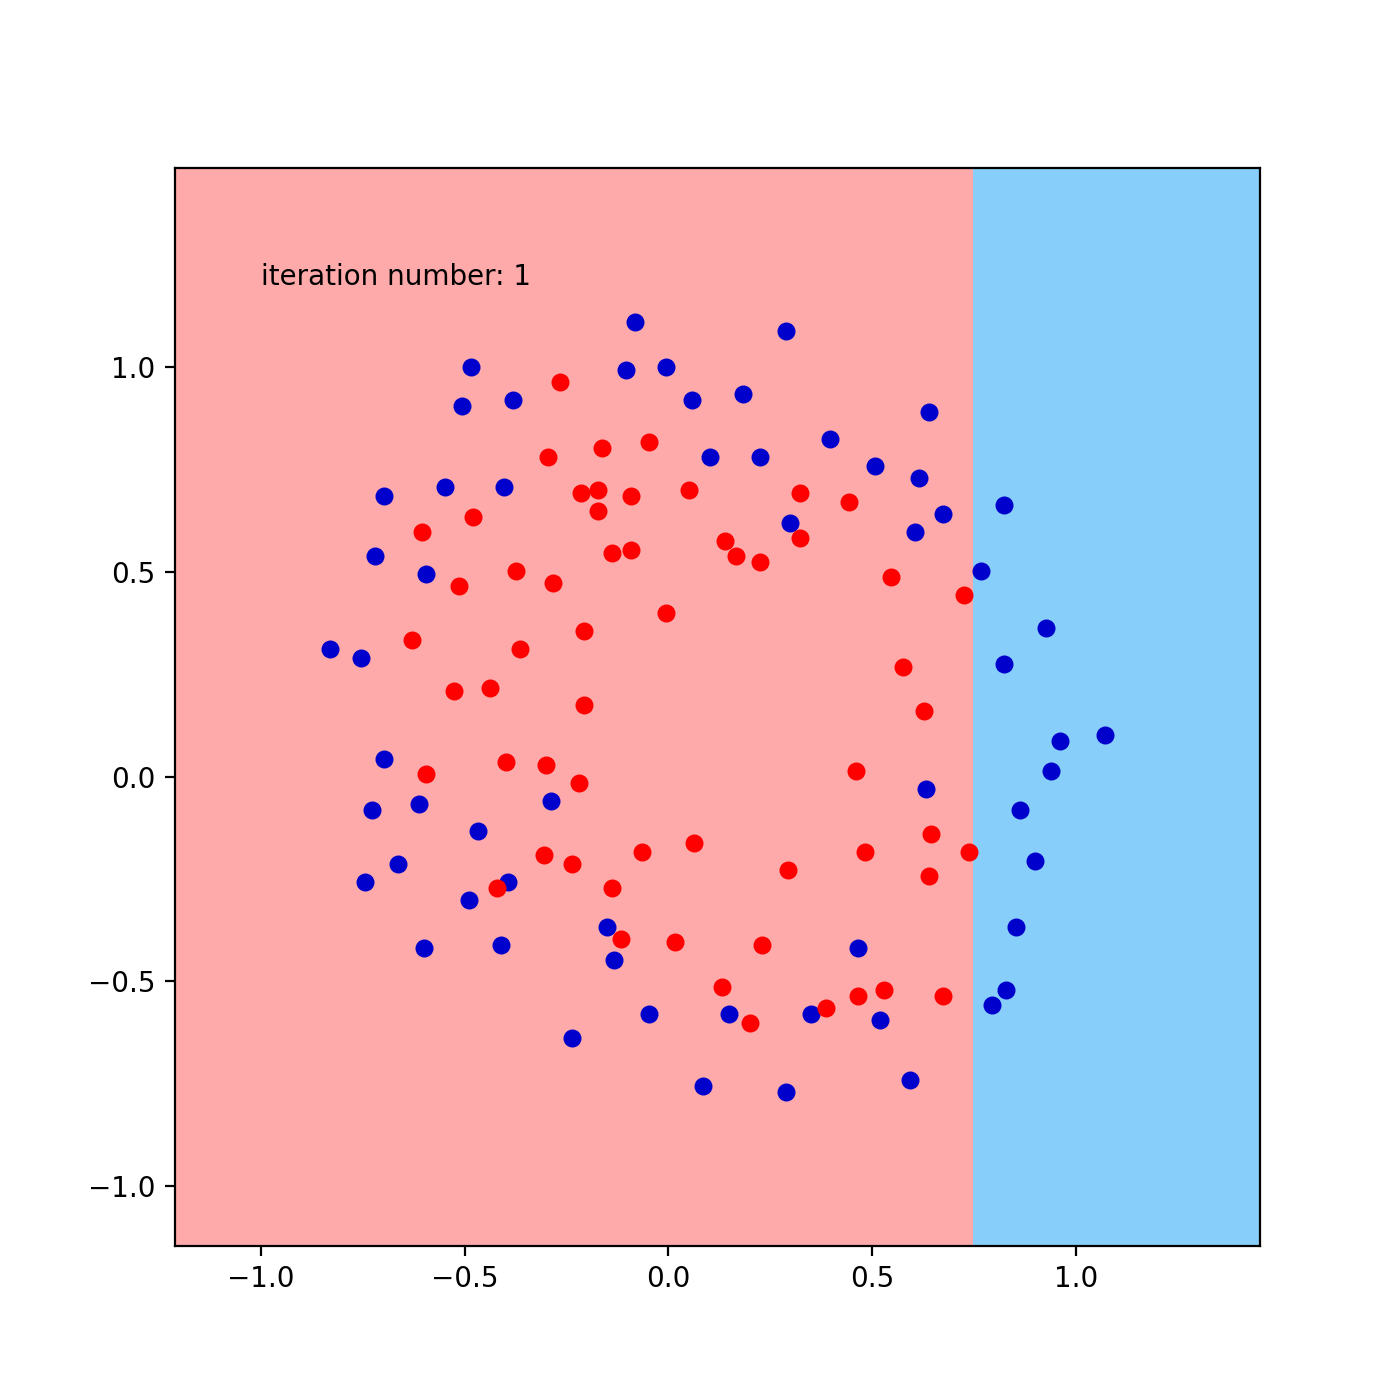

In [15]:
# selecting grid size
detalization = 40
min_x, min_y = chipsX.min()
max_x, max_y = chipsX.max()
delta_x = (max_x - min_x) / detalization;
delta_y = (max_y - min_y) / detalization;
co = detalization / 5;

points_x = np.linspace(min_x - delta_x * co, max_x + delta_x * co, int(detalization + 2 * co))
points_y = np.linspace(min_y - delta_y * co, max_y + delta_y * co, int(detalization + 2 * co))

xn, yn, _ = chips[chips['class'] == 'N'].T.values
xp, yp, _ = chips[chips['class'] == 'P'].T.values

fig, ax = plt.subplots(figsize=(7,7))
ax.axis([min_x - delta_x * co, max_x + delta_x * co,
        min_y - delta_y * co, max_y + delta_y * co])

grid = build_prediction_grid(clfs[-1], points_x, points_y)
l = ax.pcolormesh(points_x, points_y, grid, shading='auto', cmap=ListedColormap(['#87CEFA', '#FFAAAA']))
ax.scatter(xn, yn, color='#0000CD', s=30)
ax.scatter(xp, yp, color='#FF0000', s=30)
k, = ax.plot([], [])
t = ax.text(-1, 1.2, 'iteration number: {}'.format(counts[-1]))

def animate_grid(i):
    grid = build_prediction_grid(clfs[i], points_x, points_y)
    l.set_array(grid.ravel())
    t.set_text('iteration number: {}'.format(counts[i]))

ani = animation.FuncAnimation(fig, animate_grid, frames=len(clfs), interval=1000.0)

<IPython.core.display.Javascript object>


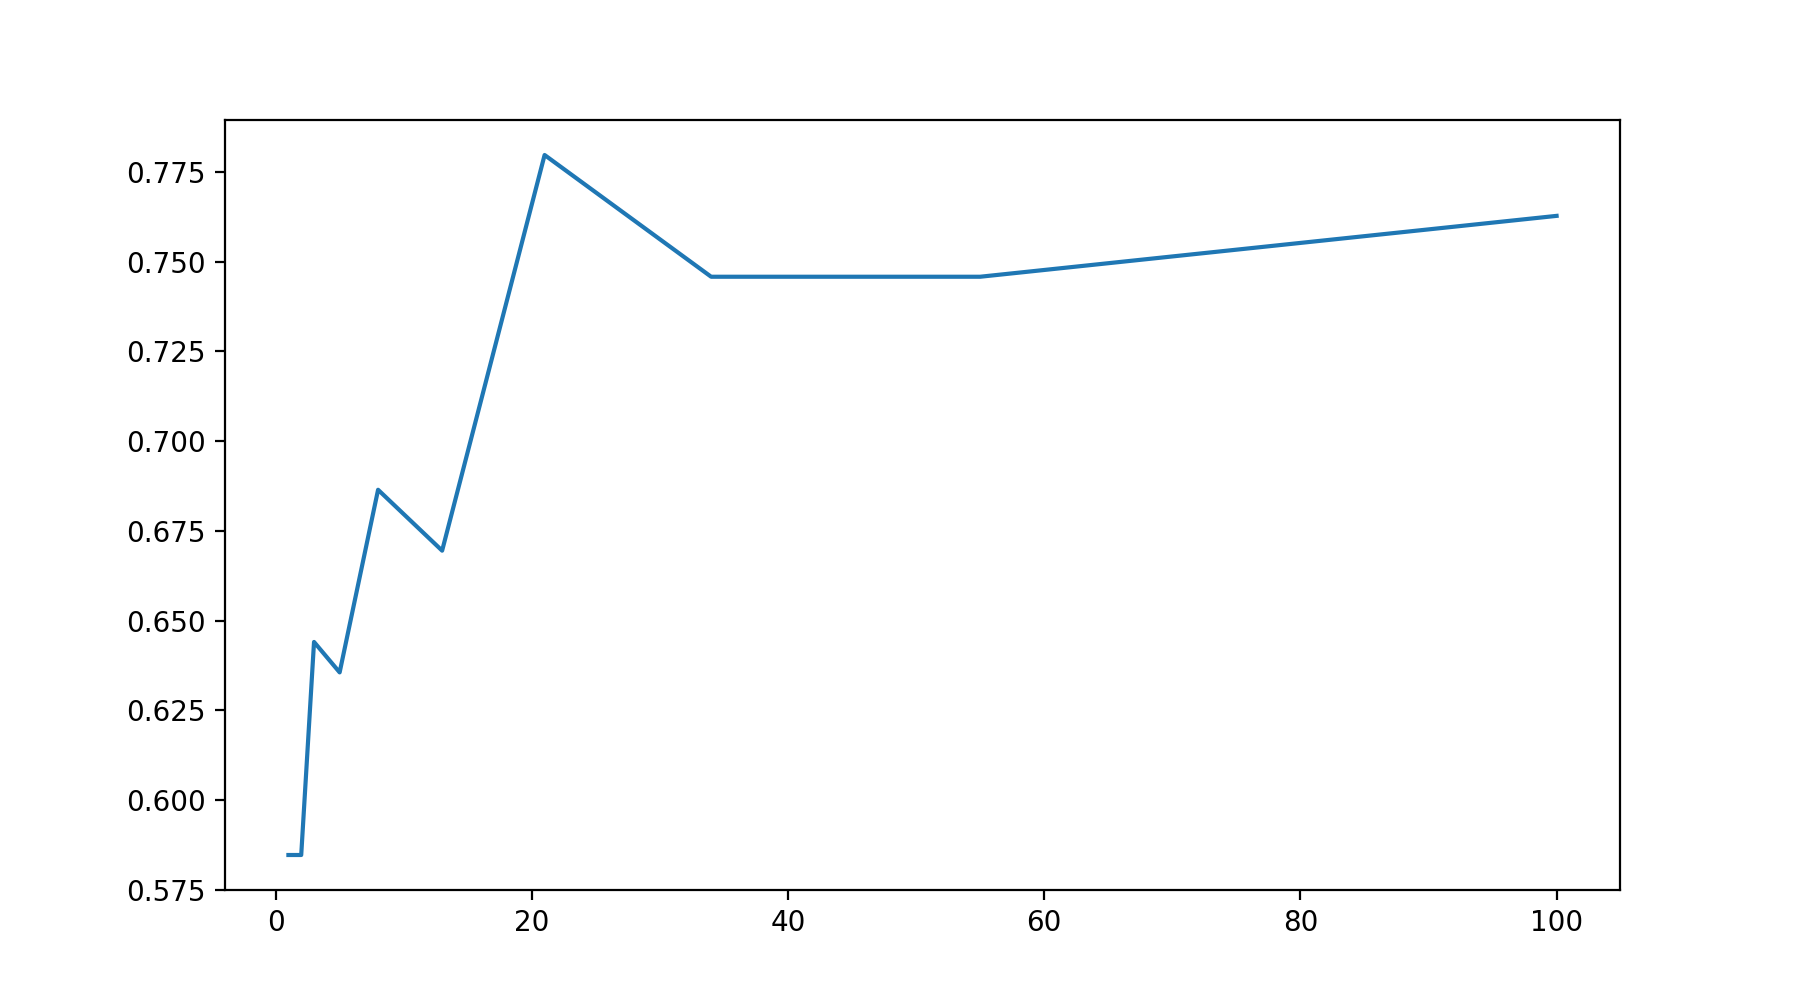

In [39]:
accs = []
for c in counts:
    clf = AdaptiveBoost(c)
    acc = cross_val_score(clf, chipsX, chipsY, cv=chipsX.shape[0], scoring='f1_macro')
    accs.append(acc.mean())
plt.figure(figsize=(9, 5))
plt.plot(counts, accs)
plt.show()

In [7]:
geyserX, geyserY = load_dataset('geyser.csv')
geyser = pd.read_csv('geyser.csv')
clfs1 = [AdaptiveBoost(c) for c in counts]
for clf in clfs1:
    clf.fit(geyserX, geyserY)

<IPython.core.display.Javascript object>


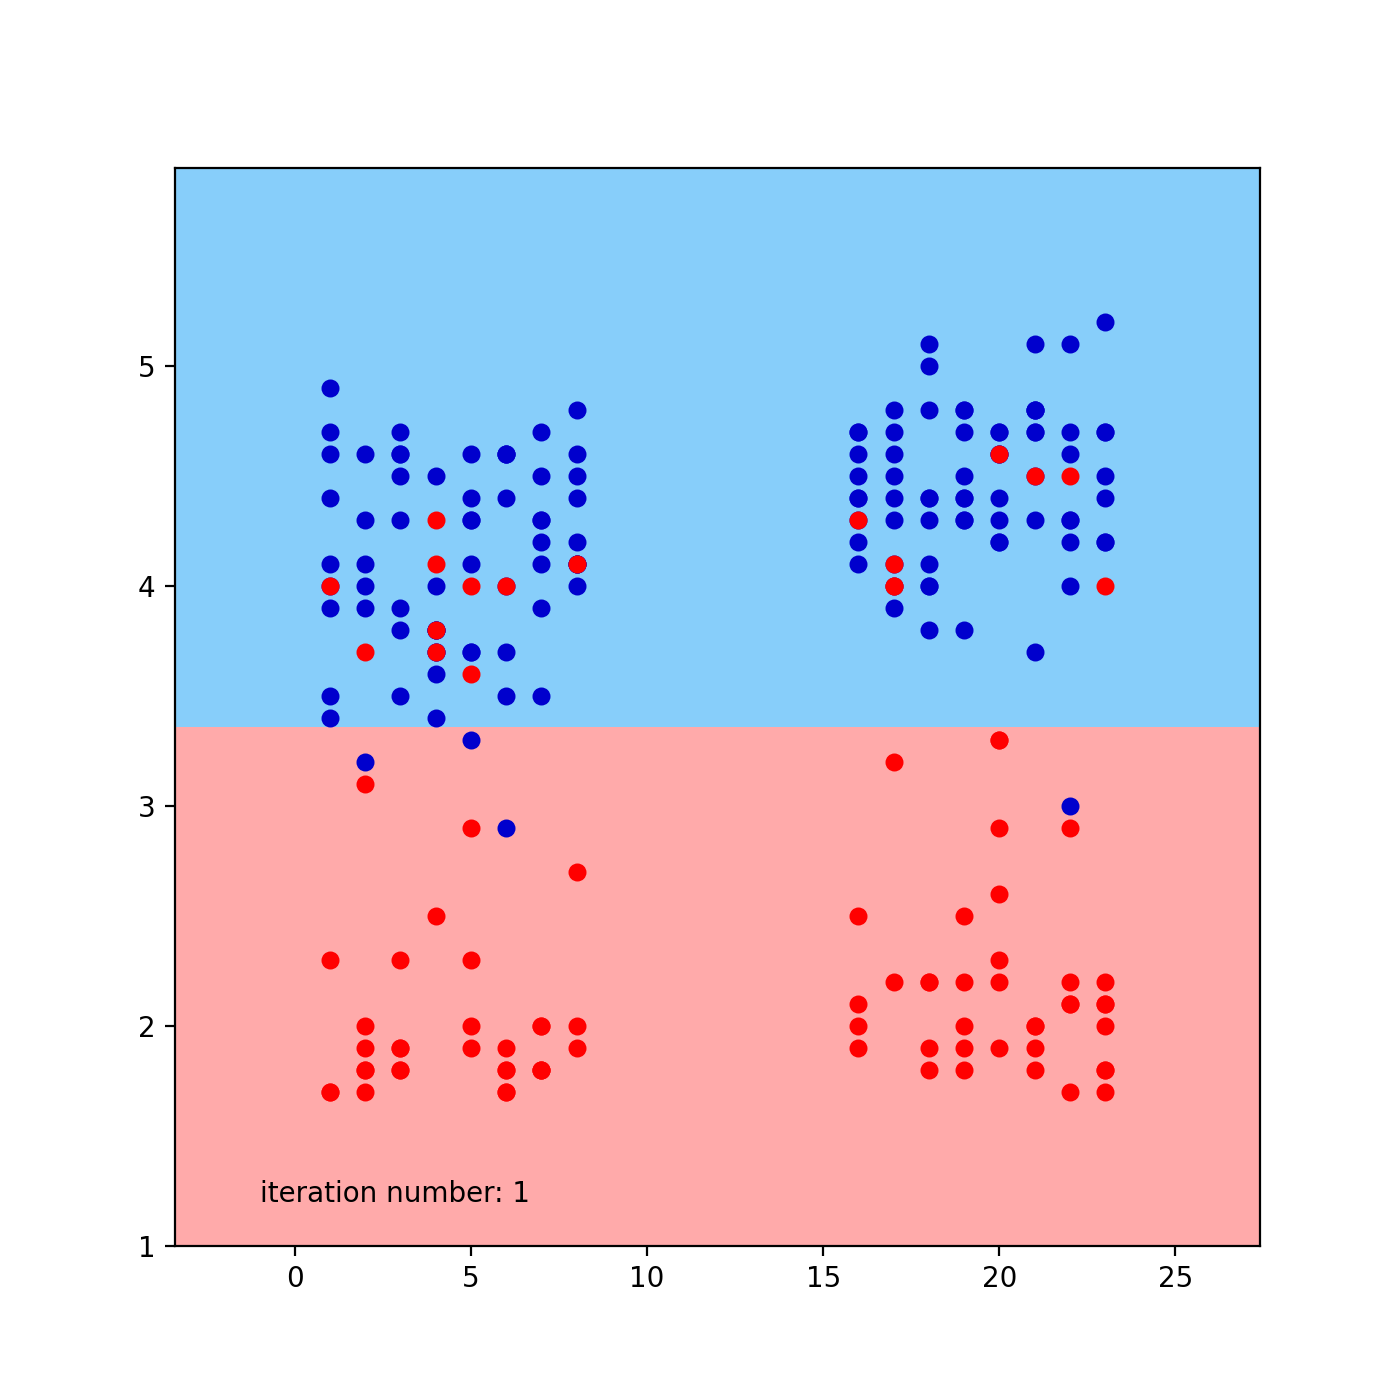

In [9]:
# selecting grid size
detalization = 40
min_x, min_y = geyserX.min()
max_x, max_y = geyserX.max()
delta_x = (max_x - min_x) / detalization;
delta_y = (max_y - min_y) / detalization;
co = detalization / 5;

points_x = np.linspace(min_x - delta_x * co, max_x + delta_x * co, int(detalization + 2 * co))
points_y = np.linspace(min_y - delta_y * co, max_y + delta_y * co, int(detalization + 2 * co))

xn, yn, _ = geyser[geyser['class'] == 'N'].T.values
xp, yp, _ = geyser[geyser['class'] == 'P'].T.values

fig, ax = plt.subplots(figsize=(7,7))
ax.axis([min_x - delta_x * co, max_x + delta_x * co,
        min_y - delta_y * co, max_y + delta_y * co])

grid = build_prediction_grid(clfs1[-1], points_x, points_y)
l = ax.pcolormesh(points_x, points_y, grid, shading='auto', cmap=ListedColormap(['#87CEFA', '#FFAAAA']))
ax.scatter(xn, yn, color='#0000CD', s=30)
ax.scatter(xp, yp, color='#FF0000', s=30)
k, = ax.plot([], [])
t = ax.text(-1, 1.2, 'iteration number: {}'.format(counts[-1]))

def animate_grid(i):
    grid = build_prediction_grid(clfs1[i], points_x, points_y)
    l.set_array(grid.ravel())
    t.set_text('iteration number: {}'.format(counts[i]))

ani = animation.FuncAnimation(fig, animate_grid, frames=len(clfs1), interval=1000.0)

<IPython.core.display.Javascript object>


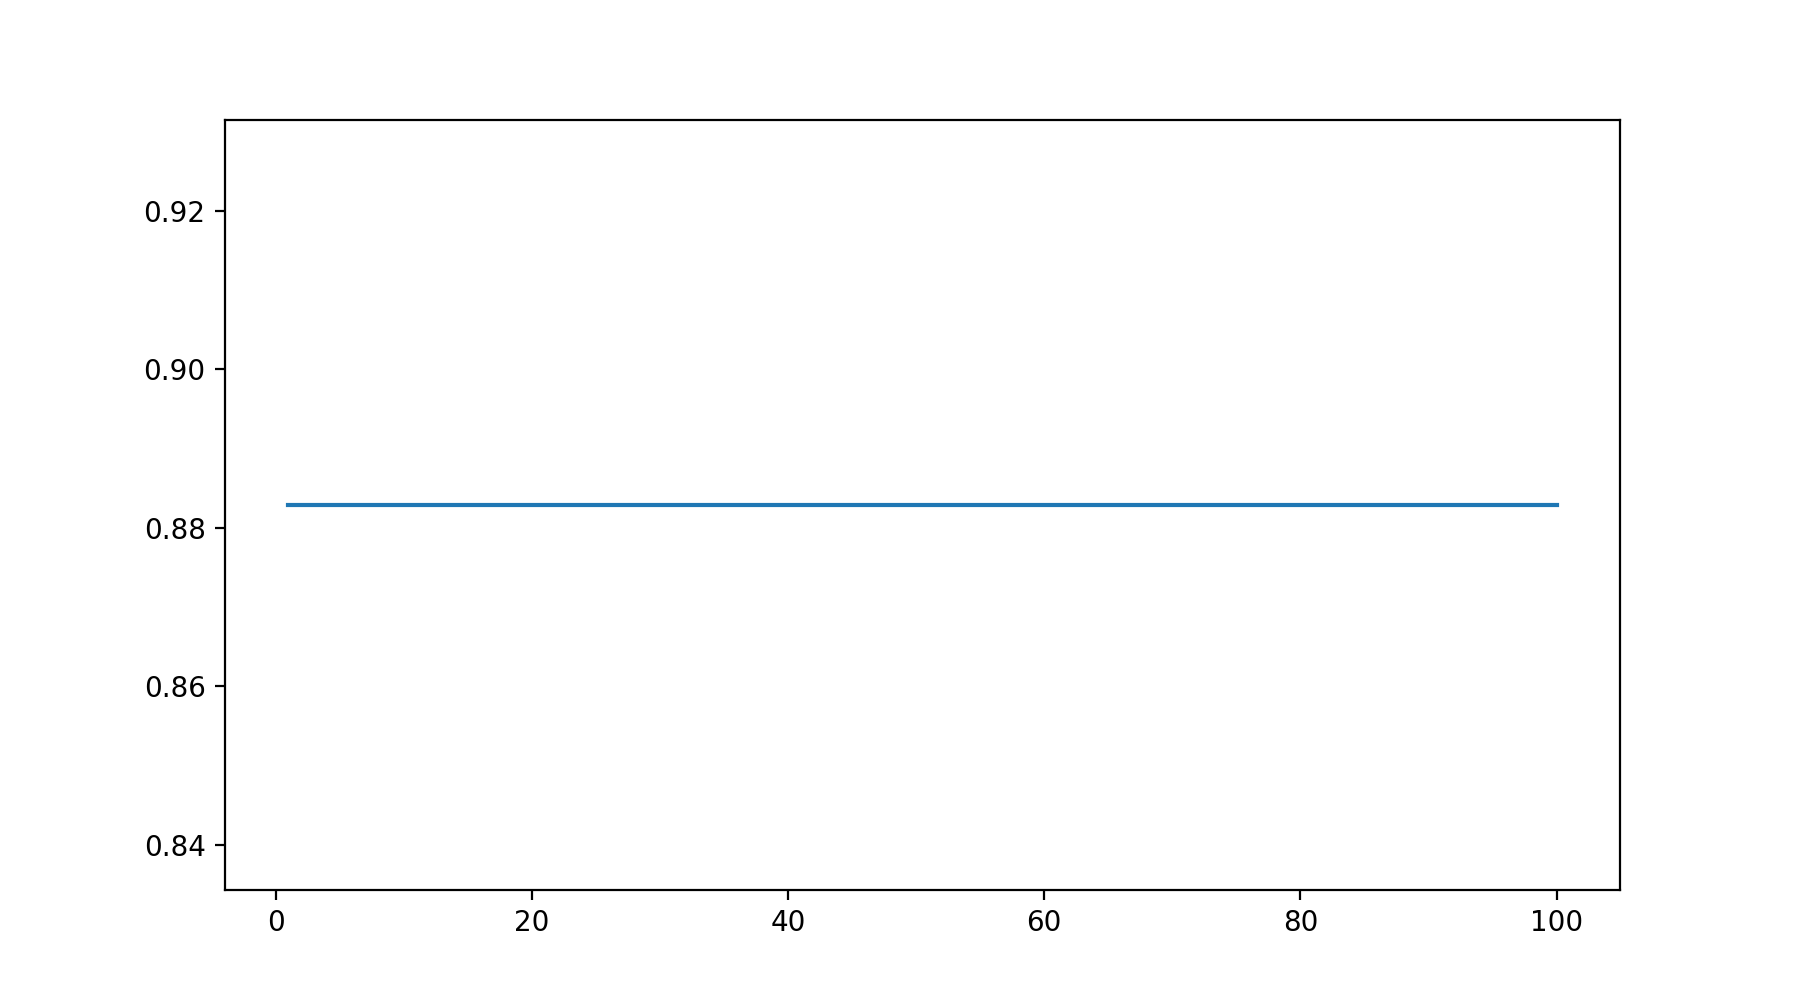

In [11]:
accs1 = []
for c in counts:
    clf = AdaptiveBoost(c)
    acc = cross_val_score(clf, geyserX, geyserY, cv=geyserX.shape[0], scoring='f1_macro')
    accs1.append(acc.mean())
plt.figure(figsize=(9, 5))
plt.plot(counts, accs1)
plt.show()